In [2101]:
!pip install staintools
!pip install spams

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2102]:
!pip install colorcorrect

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2103]:
#Loading libraries
import os
import numpy as np
import pandas as pd
import scipy
from scipy import ndimage
import cv2
import staintools
import colorcorrect.algorithm as cca
from colorcorrect.util import from_pil, to_pil
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import re

# Creates a sorted dictionary (sorted by key)
from collections import OrderedDict


import PIL
from PIL import Image
import pickle


In [2104]:
#define function saving and loading pickle
def save_obj(obj, dir_save, file_name ):
    if not os.path.exists(dir_save):
        os.mkdir(dir_save)
    
    with open(os.path.join(dir_save, file_name + '.pckl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(dir_save, file_name):
    if os.path.exists(os.path.join(dir_save, file_name + '.pckl')):
        
        with open(os.path.join(dir_save, file_name + '.pckl'), 'rb') as f:
            return pickle.load(f)
    return None


In [2105]:
# setting paths
path = os.getcwd()

experiment = 'Internal_Crop' #name of folder of the experiment. Used 'Circular_Crop', 'DeepBee', 'Internal_Crop'
data_folder = 'Data'
result_folder = 'Results'

root_path = os.path.join(path,experiment)

data_path = os.path.join(root_path,data_folder)
photo_path = os.path.join(root_path,data_folder,'photos')

result_path = os.path.join(root_path,result_folder)

if not os.path.exists(os.path.join(result_path,'resized')):
    os.mkdir(os.path.join(result_path,'resized'))


result_path_objs = os.path.join(result_path, 'objs')
if not os.path.exists(result_path_objs):
    os.mkdir(result_path_objs)
unique_Labels_List = os.listdir(data_path)



data_dir = data_path
os.listdir(root_path)




['Data', 'bckp', 'Results', 'Internal_Crop']

In [2106]:
# Set Params of Pipeline
normalization = 'ACE' #methods available 'ACE', 'MACENKO', 'VAHADANE' 
resize = 0.1 #for experiment Crop = 0.1, for DeepBee = 0.5
thresholding = 'OTSU' #methods available 'OTSU', 'ADAPTIVE_MEAN', 'ADAPTIVE_GAUSSIAN' 
min_Radius = 1 #set values for circle detection
max_Radius = 27 #set values for circle detection
blocksize = 7 #only adaptive thresholding
constant = 26 #only adaptive thresholding

In [2107]:
###########################Circle Detection function + correlation#######################
def thresholding_Hough_correl(norm_dict, thresholding, min_Radius=1, max_Radius = 27, blocksize = 11 , constant = 0):
    
    res_img_dict = {}
    circle_dict = {}
    masked_img_dict = {}
    img_area_dict = {}
    circle_folder = 'Circle_Detection'
    circle_result_path = os.path.join(result_path, circle_folder)
    maxRadius_correl_dict = {}

    if (min_Radius >= max_Radius):
        correl = 0
    else:
        n_tot_cells = 110

        print("working on thresholding method = "+ thresholding + ", blocksize = "+  str(blocksize) + " - C = "+ str(constant) + "\n"+
            " - Hough minR = "+ str(min_Radius) + ", maxR = "+ str(max_Radius))

        for key in norm_dict.keys():
            #####################################Circle Detection######################################
            #RGB2Gray conversion
            gray = cv2.cvtColor(norm_dict[key], cv2.COLOR_BGR2GRAY)

            #Thresholding
            if thresholding == 'ADAPTIVE_MEAN':
        #        th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,np.mean(norm_dict[key])*0.01)
                th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,blocksize,constant)
            elif thresholding == 'ADAPTIVE_GAUSSIAN':
                th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,blocksize,constant)
            elif thresholding == 'OTSU':
                ret,th = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            else:
                print('continue')
                continue

            res_img_dict[key] = th

            #Save inverted Otsu's mask
            inverted_img = 255-th
            path_to_Otsu_img = os.path.join(circle_result_path, 'Mask', key)
            plt.imsave(path_to_Otsu_img, inverted_img, cmap = 'gray')

            #Hough Circle Detection on Mask
            
            circles = cv2.HoughCircles(inverted_img,cv2.HOUGH_GRADIENT,1, 10,
                                    param1=25,param2=15,minRadius=min_Radius,maxRadius=max_Radius)
            
            if circles is not None:
                circles = np.uint16(np.around(circles))
                
                circle_dict[key] = circles

                #Draw Circle on mask
                input_mask = path_to_Otsu_img
                img_test = cv2.imread(input_mask)

                # ensure at least some circles were found
                # convert the (x, y) coordinates and radius of the circles to integers
                circles = np.round(circles[0, :]).astype("int")
                
                
                # loop over the (x, y) coordinates and radius of the circles
                for (x, y, r) in circles:
                    # draw the circle in the output image, then draw a rectangle
                    # corresponding to the center of the circle
                    cv2.circle(img_test, (x, y), r, (255, 0, 0), 2) 
        
                circled_img = img_test

                #Save Circled Image
                path_to_result_img = os.path.join(circle_result_path, 'Circled_Img', key)
                plt.imsave(path_to_result_img, circled_img, cmap = 'gray')

                #Measure Cells count
                n_empty_cells = len(circles)
                if experiment == 'Circular_Crop':
                    n_t24 = n_tot_cells - n_empty_cells
                else:
                    n_t24 = n_empty_cells
 #               print(n_t24)
            else:
 #               print('no circles found')
                n_t24 = None

            img_area_dict[key] = n_t24


        img_area_dict.keys()

        # EXPORT COUNTS to dataframe where img name is the index
        img_area_df = pd.DataFrame.from_dict(img_area_dict, orient = 'index')

        # IMPORT MANUAL COUNTS
        df = pd.read_csv(os.path.join(data_path,'Correl.csv'), sep = '\t')

        #dataframe where img name is the index
        df.index = df['foto']
        
        print("merging the dataframes")
        # merge the two dataframe
        df_merge = pd.merge(df, img_area_df, left_index= True, right_index= True, how = 'inner')
        print(df_merge.shape)
        
        df_merge.columns = ('foto', 'manual', 'auto')
        df_merge = df_merge.dropna()
        if df_merge.shape[0]>3:
            r = np.corrcoef(df_merge["manual"].astype('int'), df_merge["auto"].astype('int'))
            correl = r[0,1]
            if not np.isfinite(correl):
                print("correl is nan...")
                correl = 0
        else: 
            correl = 0
    return correl

In [2108]:
######################## Import Images ###############################à
img_dict = load_obj(dir_save=result_path_objs, file_name='img_dict')

if img_dict ==None:
    img_dict = load_obj(result_path_objs, 'img_dict')

    if img_dict ==None:
        img_dict = {}
        for filename in os.listdir(photo_path):
            path_to_image = os.path.join(photo_path, filename)
            image = cv2.imread(path_to_image)
            img_dict[filename] = image
    
    save_obj(dir_save=result_path_objs, file_name='img_dict', obj = img_dict)
    

print(img_dict.keys())

dict_keys(['88.jpg', '98.jpg', '90.jpg', '22.jpg', '19.jpg', '78.jpg', '9.jpg', '54.jpg', '61.jpg', '73.jpg', '6.jpg', '58.jpg', '56.jpg', '46.jpg', '18.jpg', '5.jpg', '86.jpg', '32.jpg', '75.jpg', '15.jpg', '35.jpg', '42.jpg', '1.jpg', '25.jpg', '65.jpg', '36.jpg', '60.jpg', '50.jpg', '92.jpg', '11.jpg', '71.jpg', '49.jpg', '27.jpg', '95.jpg', '2.jpg', '80.jpg', '63.jpg', '84.jpg', '59.jpg', '70.jpg', '82.jpg', '76.jpg', '91.jpg', '68.jpg', '41.jpg', '74.jpg', '94.jpg', '100.jpg', '20.jpg', '34.jpg', '79.jpg', '24.jpg', '14.jpg', '99.jpg', '21.jpg', '45.jpg', '64.jpg', '66.jpg', '3.jpg', '52.jpg', '81.jpg', '31.jpg', '69.jpg', '17.jpg', '51.jpg', '39.jpg', '13.jpg', '37.jpg', '44.jpg', '97.jpg', '55.jpg', '48.jpg', '4.jpg', '62.jpg', '87.jpg', '43.jpg', '85.jpg', '33.jpg', '30.jpg', '12.jpg', '28.jpg', '47.jpg', '77.jpg', '57.jpg', '53.jpg', '72.jpg', '29.jpg', '10.jpg', '93.jpg', '83.jpg', '26.jpg', '67.jpg', '16.jpg', '40.jpg', '96.jpg', '38.jpg', '7.jpg', '8.jpg', '23.jpg', '89.jpg

In [2109]:
#########################Normalization######################
normalization == 'ACE'
dir_smooth = os.path.join(result_path,'gaussian_filter')

if not os.path.exists(os.path.join(result_path,'Circle_Detection')):
    os.mkdir(os.path.join(result_path,'Circle_Detection'))
    os.mkdir(os.path.join(result_path,'Circle_Detection','Mask'))
    os.mkdir(os.path.join(result_path,'Circle_Detection','Circled_Img'))
    os.mkdir(os.path.join(result_path,'Circle_Detection','Masked_Circle_Img'))

if not os.path.exists(os.path.join(result_path,normalization + '_normalized')):
    os.mkdir(os.path.join(result_path,normalization + '_normalized'))

In [2110]:
#########################Normalization######################
norm_dict = {}
target_path = os.path.join(data_path,'target_norm/DSC00037.JPG')

for key in img_dict.keys():
    print(key)

    path_to_result_img = os.path.join(dir_smooth, key)

    #Filtering
    if os.path.exists(path_to_result_img):
        print(key + " after gaussian exists: I'm reading it")
        gauss_img = cv2.imread(path_to_result_img)
    else:
        print(key + " after gaussian does not exist: I'm creating it")
        mf_img = cv2.medianBlur(img_dict[key], 5)     #median filter
        gauss_img = cv2.GaussianBlur(mf_img, (3,3), 5) # 3x3 gaussian blur
        plt.imsave(path_to_result_img, gauss_img)

    if normalization == 'vahadane':
        if not os.path.exists( os.path.join(result_path, normalization + '_normalized', key)):
            #Sample target img for normalization
            target = cv2.imread(target_path)
            to_transform = gauss_img

            #Stain normalization
            normalizer = staintools.StainNormalizer(method='vahadane') #method 'macenko' as alternative
            normalizer.fit(target)
            transformed = normalizer.transform(to_transform)
            
            #Save img to dict and to result folder
            norm_dict[key] = transformed
            path_to_result_img = os.path.join(result_path, normalization + '_normalized', key)
            plt.imsave(path_to_result_img, transformed)
        else:
            print("already normalized")
            
    elif normalization == 'macenko':
        if not os.path.exists(os.path.join(result_path, normalization + '_normalized', key)):        
            #Sample target img for normalization
            target = cv2.imread(target_path)
            to_transform = gauss_img
        
            #Stain normalization
            normalizer = staintools.StainNormalizer(method='macenko') #method 'vahadane' as alternative
            normalizer.fit(target)
            transformed = normalizer.transform(to_transform)
            
            #Save img to dict and to result folder
            norm_dict[key] = transformed
            path_to_result_img = os.path.join(result_path, normalization + '_normalized', key)
            plt.imsave(path_to_result_img, transformed)
        else:
            print("already normalized")

    elif normalization == 'ACE':
        if not os.path.exists( os.path.join(result_path, normalization + '_normalized', key)):
            to_transform = Image.open(os.path.join(dir_smooth, key))
            #ACE normalization and Save img to result folder
            path_to_result_img = os.path.join(result_path, normalization + '_normalized', key)

            to_pil(cca.automatic_color_equalization(from_pil(to_transform))).save(path_to_result_img)
        else:
            print("already normalized")
            
    else:
        continue

88.jpg
88.jpg after gaussian exists: I'm reading it
already normalized
98.jpg
98.jpg after gaussian exists: I'm reading it
already normalized
90.jpg
90.jpg after gaussian exists: I'm reading it
already normalized
22.jpg
22.jpg after gaussian exists: I'm reading it
already normalized
19.jpg
19.jpg after gaussian exists: I'm reading it
already normalized
78.jpg
78.jpg after gaussian exists: I'm reading it
already normalized
9.jpg
9.jpg after gaussian exists: I'm reading it
already normalized
54.jpg
54.jpg after gaussian exists: I'm reading it
already normalized
61.jpg
61.jpg after gaussian exists: I'm reading it
already normalized
73.jpg
73.jpg after gaussian exists: I'm reading it
already normalized
6.jpg
6.jpg after gaussian exists: I'm reading it
already normalized
58.jpg
58.jpg after gaussian exists: I'm reading it
already normalized
56.jpg
56.jpg after gaussian exists: I'm reading it
already normalized
46.jpg
46.jpg after gaussian exists: I'm reading it
already normalized
18.jpg
18.

In [2111]:
############# Resizing while extracting train and test images ############
from random import random

struct_load = load_obj(dir_save = result_path_objs, file_name = 'all_norm_dicts')

if struct_load == None:
    if normalization == '':
        norm_path = dir_smooth
    else:
        norm_path = os.path.join(result_path, normalization+'_normalized')

    norm_dict = {}
    norm_dict_train = {}
    idx_train = []
    norm_dict_test = {}
    num_train = 50
    count = 0
    idx = 0
    for filename in img_dict.keys():
        path_to_image = os.path.join(norm_path, filename)
        print(path_to_image)
        
        image = cv2.imread(path_to_image)
        
        scale_percent = resize # percent of original size
        width = int(image.shape[1] * scale_percent)
        height = int(image.shape[0] * scale_percent)
        dim = (width, height)
        # resize image
        resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

        norm_dict[filename] = resized
        if (random()>0.5) & (count < num_train):
            norm_dict_train[filename] = resized
            idx_train.append(idx)
            count = count+1
        else:
            norm_dict_test[filename] = resized
        
        #Save img to dict and to result folder
        path_to_result_img = os.path.join(result_path, 'resized', filename)
        plt.imsave(path_to_result_img, resized)
        idx = idx+1
else:
    norm_dict = struct_load[0]
    norm_dict_test = struct_load[1] 
    norm_dict_train = struct_load[2]

/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/88.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/98.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/90.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/22.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/19.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/78.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/9.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/54.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/61.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/73.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Cr

/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/93.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/83.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/26.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/67.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/16.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/40.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/96.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/38.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/7.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Crop/Results/ACE_normalized/8.jpg
/home/gpaolillo/Desktop/Comb_Images_Pipeline_test/Internal_Cro

In [2112]:
print(norm_dict.keys())

dict_keys(['88.jpg', '98.jpg', '90.jpg', '22.jpg', '19.jpg', '78.jpg', '9.jpg', '54.jpg', '61.jpg', '73.jpg', '6.jpg', '58.jpg', '56.jpg', '46.jpg', '18.jpg', '5.jpg', '86.jpg', '32.jpg', '75.jpg', '15.jpg', '35.jpg', '42.jpg', '1.jpg', '25.jpg', '65.jpg', '36.jpg', '60.jpg', '50.jpg', '92.jpg', '11.jpg', '71.jpg', '49.jpg', '27.jpg', '95.jpg', '2.jpg', '80.jpg', '63.jpg', '84.jpg', '59.jpg', '70.jpg', '82.jpg', '76.jpg', '91.jpg', '68.jpg', '41.jpg', '74.jpg', '94.jpg', '100.jpg', '20.jpg', '34.jpg', '79.jpg', '24.jpg', '14.jpg', '99.jpg', '21.jpg', '45.jpg', '64.jpg', '66.jpg', '3.jpg', '52.jpg', '81.jpg', '31.jpg', '69.jpg', '17.jpg', '51.jpg', '39.jpg', '13.jpg', '37.jpg', '44.jpg', '97.jpg', '55.jpg', '48.jpg', '4.jpg', '62.jpg', '87.jpg', '43.jpg', '85.jpg', '33.jpg', '30.jpg', '12.jpg', '28.jpg', '47.jpg', '77.jpg', '57.jpg', '53.jpg', '72.jpg', '29.jpg', '10.jpg', '93.jpg', '83.jpg', '26.jpg', '67.jpg', '16.jpg', '40.jpg', '96.jpg', '38.jpg', '7.jpg', '8.jpg', '23.jpg', '89.jpg

In [2113]:
print(norm_dict_test.keys())

dict_keys(['98.jpg', '90.jpg', '22.jpg', '19.jpg', '61.jpg', '73.jpg', '6.jpg', '58.jpg', '56.jpg', '18.jpg', '5.jpg', '75.jpg', '35.jpg', '42.jpg', '1.jpg', '25.jpg', '65.jpg', '92.jpg', '11.jpg', '49.jpg', '27.jpg', '2.jpg', '80.jpg', '63.jpg', '84.jpg', '59.jpg', '91.jpg', '41.jpg', '74.jpg', '94.jpg', '100.jpg', '20.jpg', '34.jpg', '79.jpg', '99.jpg', '64.jpg', '66.jpg', '81.jpg', '31.jpg', '69.jpg', '51.jpg', '97.jpg', '4.jpg', '43.jpg', '33.jpg', '47.jpg', '53.jpg', '29.jpg', '40.jpg', '89.jpg'])


In [2114]:
print(norm_dict_train.keys())

dict_keys(['88.jpg', '78.jpg', '9.jpg', '54.jpg', '46.jpg', '86.jpg', '32.jpg', '15.jpg', '36.jpg', '60.jpg', '50.jpg', '71.jpg', '95.jpg', '70.jpg', '82.jpg', '76.jpg', '68.jpg', '24.jpg', '14.jpg', '21.jpg', '45.jpg', '3.jpg', '52.jpg', '17.jpg', '39.jpg', '13.jpg', '37.jpg', '44.jpg', '55.jpg', '48.jpg', '62.jpg', '87.jpg', '85.jpg', '30.jpg', '12.jpg', '28.jpg', '77.jpg', '57.jpg', '72.jpg', '10.jpg', '93.jpg', '83.jpg', '26.jpg', '67.jpg', '16.jpg', '96.jpg', '38.jpg', '7.jpg', '8.jpg', '23.jpg'])


In [2115]:
################################################### GRID SEARCH #####################################

In [2116]:
############### OTSU MAX RADIUS PARAM SEARCH ##################

In [2117]:
thresholding ='OTSU'
minR= 1
maxR= 25
blocksize = 0
constant = 0
norm_dict = norm_dict_train

correl = thresholding_Hough_correl(norm_dict_train,thresholding = thresholding,min_Radius = minR,max_Radius = maxR,blocksize= None,constant = None)
print(correl)

working on thresholding method = OTSU, blocksize = None - C = None
 - Hough minR = 1, maxR = 25
merging the dataframes
(50, 3)
0.924720872730489


In [2118]:
file_name = 'maxR_OTSU_correl_dict'

struct_load =  load_obj(dir_save = result_path_objs, file_name = file_name)

if struct_load == None:
    OTSU_correl_dict = {}
    minv = 2
    maxv = 101
    stepv = 1
    for maxR in range(minv,maxv,stepv):
        correl = thresholding_Hough_correl(norm_dict_train,thresholding = 'OTSU',max_Radius=maxR)
        key = 'maxRadius' + str(maxR)
        OTSU_correl_dict[maxR] = correl

    plt.bar(list(range(minv,maxv,stepv)), OTSU_correl_dict.values(), color='b')
    #plt.title('OTSU MAX RADIUS CORRELATION')
    plt.xlabel('Maximum Radius')
    plt.ylabel('Correlation')
    plt.savefig(os.path.join(result_path, 'OTSU_maxRadius_plot.pdf'))
    plt.show()


    print("all correlation Values ")
    for k, v in OTSU_correl_dict.items(): print(k, v)

    # get key with max value
    best_maxRadius = max(OTSU_correl_dict, key=OTSU_correl_dict.get)


    print("best correlation = "+str(OTSU_correl_dict[best_maxRadius])+" at Radius =" + str(best_maxRadius))

    save_obj(obj = (OTSU_correl_dict, best_maxRadius), dir_save = result_path_objs, file_name = 'maxR_OTSU_correl_dict')

else:
    OTSU_correl_dict = struct_load[0] 
    best_maxRadius = struct_load[1]


In [2119]:
file_name = 'minR_OTSU_correl_dict'

struct_load =  load_obj(dir_save = result_path_objs, file_name = file_name)


if struct_load == None:

    min_OTSU_correl_dict = {}

    minv =1
    for minR in range(minv,best_maxRadius+1,stepv):
        correl = thresholding_Hough_correl(norm_dict_train,thresholding = thresholding,min_Radius = minR,max_Radius=best_maxRadius)
        min_OTSU_correl_dict[minR] = correl

    plt.bar(list(range(minv,best_maxRadius+1,stepv)), min_OTSU_correl_dict.values(), color='b')
    #plt.title('OTSU MAX RADIUS CORRELATION')
    plt.xlabel('Minimum Radius')
    plt.ylabel('Correlation')
    plt.savefig(os.path.join(result_path, 'OTSU_minRadius_plot.pdf'))
    plt.show()


    print("all correlation Values ")
    for k, v in min_OTSU_correl_dict.items(): print(k, v)



    # get key with max value
    best_minRadius = max(min_OTSU_correl_dict, key=min_OTSU_correl_dict.get)


    print("best correlation = "+str(min_OTSU_correl_dict[best_minRadius])+" at Radius =" + str(best_minRadius))


    save_obj(obj = (min_OTSU_correl_dict, best_minRadius), dir_save = result_path_objs, file_name = 'minR_OTSU_correl_dict')

else:
    min_OTSU_correl_dict = struct_load[0] 
    best_minRadius = struct_load[1]

In [2120]:
print(best_minRadius, best_maxRadius)

4 27


In [2121]:
##################### TWO PARAM OTSU GRID PARAM SEARCH ######################À

In [2122]:
struct_load = load_obj(dir_save = result_path_objs, file_name = 'twoWay_OTSU_correl_dict')
maxv = 75
if struct_load ==None:

    #if struct_load ==None:
    two_param_OTSU_correl_dict = {}
    maxv = 75
    df_otsu = np.zeros(shape=(maxv,maxv))

    for min_Radius in range(1,maxv+1,1):
        for max_Radius in range(1,maxv+1,1):
            correl = thresholding_Hough_correl(norm_dict_train,'OTSU',min_Radius,max_Radius)
            key = (min_Radius,max_Radius)
            two_param_OTSU_correl_dict[key] = correl
            df_otsu[min_Radius-1, max_Radius-1] = correl
        
    # get key with max value
    (best_minR_twoWay, best_maxR_twoWay) = max(two_param_OTSU_correl_dict, key=two_param_OTSU_correl_dict.get)

    print("best correlation = "+str(two_param_OTSU_correl_dict[(best_minR_twoWay, best_maxR_twoWay)])+" at Radiuses =" + str((best_minR_twoWay, best_maxR_twoWay)))
    save_obj( obj = (two_param_OTSU_correl_dict, df_otsu, best_minR_twoWay, best_maxR_twoWay), dir_save = result_path_objs, file_name = 'twoWay_OTSU_correl_dict')
else:
    two_param_OTSU_correl_dict = struct_load[0] 
    df_otsu = struct_load[1]
#    (best_minR_twoWay, best_maxR_twoWay) = max(df_otsu, key=df_otsu.get)
    best_minR_twoWay = struct_load[2] 
    best_maxR_twoWay = struct_load[3]

print('\n'+'correlation on train images with best params from 2d grid search:' +str(df_otsu[best_minR_twoWay-1,best_maxR_twoWay-1]))
#################### OTSU CORRELATION ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = thresholding,min_Radius = best_minR_twoWay, max_Radius=best_maxR_twoWay)

print("correlation on test images with best params from 2D grid search: minR = "+str(best_minR_twoWay)+" - maxR = "+ str(best_maxR_twoWay) + " = " + str(correl))


correlation on train images with best params from 2d grid search:0.9470806056258586
working on thresholding method = OTSU, blocksize = 11 - C = 0
 - Hough minR = 4, maxR = 27
merging the dataframes
(50, 3)
correlation on test images with best params from 2D grid search: minR = 4 - maxR = 27 = 0.8232040375235191


In [2123]:
best_minR_twoWay, best_maxR_twoWay

(4, 27)

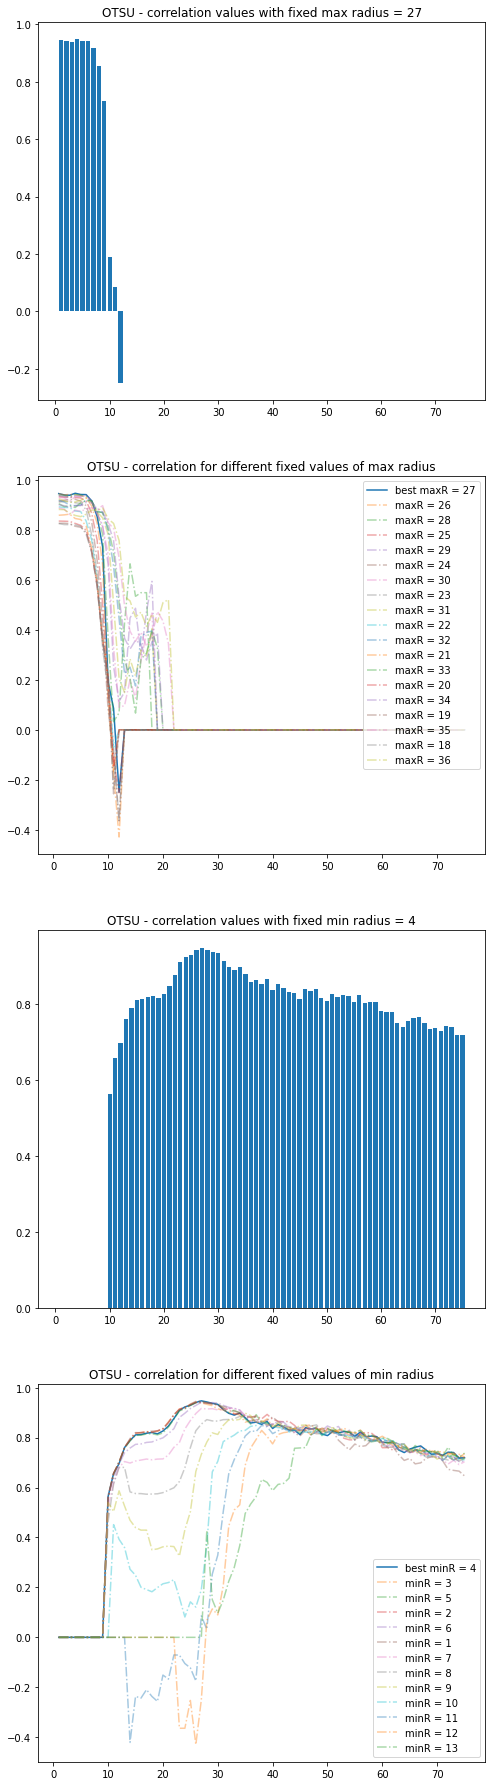

In [2124]:
fig, ax_bar = plt.subplots(4,1, figsize=(8,32))

ax_bar[0].bar(np.arange(1,maxv+1,1),df_otsu[:,best_maxR_twoWay-1])
ax_bar[0].set_title('OTSU - correlation values with fixed max radius = '+str(best_maxR_twoWay))

ax_bar[1].plot(np.arange(1,maxv+1,1),df_otsu[:, best_maxR_twoWay-1], label='best maxR = ' + str(best_maxR_twoWay))
for j in np.arange(1,10,1):
    ax_bar[1].plot(np.arange(1,maxv+1,1),df_otsu[:, best_maxR_twoWay-1-j], '-.', alpha = 0.4,  label="maxR = " +str(best_maxR_twoWay-j))
    ax_bar[1].plot(np.arange(1,maxv+1,1),df_otsu[:, best_maxR_twoWay-1+j], '-.', alpha = 0.4, label="maxR = " +str(best_maxR_twoWay+j))
ax_bar[1].legend(loc = 'upper right')
ax_bar[1].set_title('OTSU - correlation for different fixed values of max radius')


ax_bar[2].bar(np.arange(1,maxv+1,1),df_otsu[best_minR_twoWay-1,:])
ax_bar[2].set_title('OTSU - correlation values with fixed min radius = '+str(best_minR_twoWay))

ax_bar[3].plot(np.arange(1,maxv+1,1),df_otsu[best_minR_twoWay-1,:], label='best minR = ' + str(best_minR_twoWay))
for j in np.arange(1,10,1):
    if (best_minR_twoWay-j >0):
        ax_bar[3].plot(np.arange(1,maxv+1,1),df_otsu[best_minR_twoWay-1-j,:], '-.', alpha = 0.4,  label="minR = " +str(best_minR_twoWay-j))
    ax_bar[3].plot(np.arange(1,maxv+1,1),df_otsu[best_minR_twoWay-1+j,:], '-.', alpha = 0.4, label="minR = " +str(best_minR_twoWay+j))
ax_bar[3].legend(loc = 'lower right')
ax_bar[3].set_title('OTSU - correlation for different fixed values of min radius')

plt.savefig(os.path.join(result_path, 'OTSU_minMaxRadius_distribution.pdf'))



(13, 39) (13, 39) (13, 39)


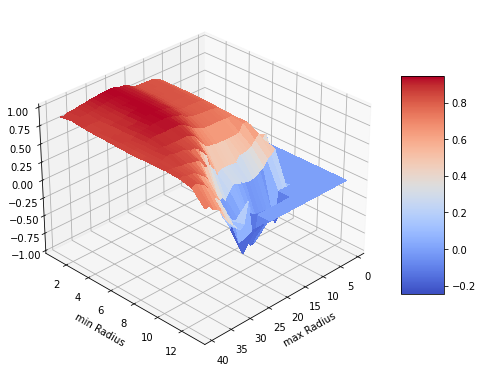

In [2125]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))

# Make data.
maxMinR = 14
maxMaxR = 40
Y = np.arange(1,maxMinR, 1)
X = np.arange(1,maxMaxR, 1)
X, Y = np.meshgrid(X, Y)
df_otsu[np.where(np.isnan(df_otsu))] = 0
Z = df_otsu[np.arange(0,maxMinR-1,1),:]
Z = Z[:, np.arange(0,maxMaxR-1,1)]

print(X.shape, Y.shape, Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.00, 1.00)
#ax.zaxis.set_major_locator(LinearLocator(0))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('max Radius')
ax.set_ylabel('min Radius')
#ax.view_init(20, +30)
ax.view_init(30, +45)
#ax.set_title('OTSU MIN MAX RADIUS CORRELATION')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig(os.path.join(result_path, 'OTSU_minMaxRadius_surface.pdf'))

plt.show()


In [2126]:
print(df_otsu)

[[0.         0.         0.         ... 0.66861123 0.66556077 0.64634879]
 [0.         0.         0.         ... 0.7103587  0.72229825 0.72295826]
 [0.         0.         0.         ... 0.73852203 0.72023579 0.73539386]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [2127]:
################################# ADAPTIVE THRESHOLDING ########################

In [2128]:
######################## ADAPTIVE MEAN THREE PARAMS GRID SEARCH######################

In [2129]:
maxC = 60
minBsize = 3
maxBsize = 50

maxRadius = 50
minR =  best_minR_twoWay
struct_load = load_obj(dir_save = result_path_objs, file_name = 'adaptive_mean_correl_dict')

if struct_load==None:

    adaptive_mean_correl_dict = {}

    df_adaptive_mean = np.zeros(shape=(len(range(0,maxC,4)),len(range(minBsize,maxBsize,2)), 1, maxRadius ))
    
    idx_C =-1   
    #for maxRadius in range(11,41,2):
    for C in range(0,maxC,4):
        idx_C = idx_C + 1  
        idx_b =-1
        for bsize in range(minBsize,maxBsize,4):
            idx_b = idx_b + 1
            #for minR in best_minR_twoWay:
            for maxR in range(15,45,1):            
                correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_MEAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                adaptive_mean_correl_dict[(bsize, C, minR, maxR)] = correl  
                df_adaptive_mean[idx_C, idx_b, 0, maxR-1] = correl

    save_obj( obj = (adaptive_mean_correl_dict, df_adaptive_mean), dir_save = result_path_objs, file_name = 'adaptive_mean_correl_dict')
else:
    adaptive_mean_correl_dict = struct_load[0] 
    df_adaptive_mean = struct_load[1]

    # get key with max value
(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive) = max(adaptive_mean_correl_dict, key=adaptive_mean_correl_dict.get)

print("best correlation on training set = "+str(adaptive_mean_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE MEAN ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_MEAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


best correlation on training set = 0.9434246908702134 at Radiuses = 4, 15 - C = 20 - blocksize = 7
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 4, maxR = 15
merging the dataframes
(50, 3)
correlation on test images [with best params: minR = 4 - maxR = 15 - C = 20 - blocksize7] = 0.9389240364180342


In [2130]:
######################## ADAPTIVE MEAN BEST C AND BSIZE RADIUSES SEARCH######################

In [2131]:
bsize = best_b_size_adaptive
C = best_C_adaptive    
maxRadius = 50

struct_load = load_obj(dir_save = result_path_objs, file_name = 'adaptive_mean_correl_dict_radiuses')

if struct_load==None:
    print('create dict')
    adaptive_mean_correl_dict = {}
    df_adaptive_mean = np.zeros(shape=(maxRadius, maxRadius ))
    for minR in range(1,maxRadius,1):
        for maxR in range(minR+1,maxRadius,1):            
            correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_MEAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
            adaptive_mean_correl_dict[(minR, maxR)] = correl  
            df_adaptive_mean[minR-1, maxR-1] = correl

    save_obj( obj = (adaptive_mean_correl_dict, df_adaptive_mean), dir_save = result_path_objs, file_name = 'adaptive_mean_correl_dict_radiuses')
else:
    adaptive_mean_correl_dict = struct_load[0] 
    df_adaptive_mean = struct_load[1]

    # get key with max value
(best_minR_adaptive, best_maxR_adaptive) = max(adaptive_mean_correl_dict, key=adaptive_mean_correl_dict.get)

print("best correlation = "+str(adaptive_mean_correl_dict[(best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE MEAN CORRELATION ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_MEAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


best correlation = 0.9625762027461935 at Radiuses = 3, 12 - C = 20 - blocksize = 7
working on thresholding method = ADAPTIVE_MEAN, blocksize = 7 - C = 20
 - Hough minR = 3, maxR = 12
merging the dataframes
(50, 3)
correlation on test images [with best params: minR = 3 - maxR = 12 - C = 20 - blocksize7] = 0.9519993887378011


In [2132]:
############ GLOBAL ADAPTIVE MEAN PARAM SEARCH ####################

In [2133]:
struct_load = load_obj(dir_save = result_path_objs, file_name = 'global_adaptive_mean_correl_dict')

if struct_load==None:

    adaptive_mean_correl_dict = {}

    df_adaptive_mean = np.zeros(shape=(10, 5, 9, 9))

    idx_C =-1   
    #for maxRadius in range(11,41,2):
    for C in range(best_C_adaptive-9,best_C_adaptive+10,2):
        idx_C = idx_C + 1  
        idx_b =-1
        if best_b_size_adaptive == 3:
            for bsize in range(best_b_size_adaptive,best_b_size_adaptive+9,2):
                idx_b = idx_b + 1
                idx_minR =-1
                for minR in range(best_minR_adaptive-4,best_minR_adaptive+5,1):
                    idx_minR = idx_minR + 1
                    idx_maxR =-1
                    for maxR in range(best_maxR_adaptive-4,best_maxR_adaptive+5,1):
                        idx_maxR = idx_maxR + 1
                        correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                        adaptive_mean_correl_dict[(bsize, C, minR, maxR)] = correl  
                        df_adaptive_mean[idx_C, idx_b, idx_minR, idx_maxR] = correl
        else:
            for bsize in range(best_b_size_adaptive-4,best_b_size_adaptive+5,2):
                idx_b = idx_b + 1
                idx_minR =-1
                for minR in range(best_minR_adaptive-4,best_minR_adaptive+5,1):
                    idx_minR = idx_minR + 1
                    idx_maxR =-1
                    for maxR in range(best_maxR_adaptive-4,best_maxR_adaptive+5,1):
                        idx_maxR = idx_maxR + 1
                        correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                        adaptive_mean_correl_dict[(bsize, C, minR, maxR)] = correl  
                        df_adaptive_mean[idx_C, idx_b, idx_minR, idx_maxR] = correl

    save_obj( obj = (adaptive_mean_correl_dict, df_adaptive_mean), dir_save = result_path_objs, file_name = 'global_adaptive_mean_correl_dict')
else:
    adaptive_mean_correl_dict = struct_load[0] 
    df_adaptive_mean = struct_load[1]

    # get key with max value
(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive) = max(adaptive_mean_correl_dict, key=adaptive_mean_correl_dict.get)

print("best correlation on training set = "+str(adaptive_mean_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE MEAN ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_MEAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


best correlation on training set = 0.9612237961787147 at Radiuses = 3, 12 - C = 21 - blocksize = 9
working on thresholding method = ADAPTIVE_MEAN, blocksize = 9 - C = 21
 - Hough minR = 3, maxR = 12
merging the dataframes
(50, 3)
correlation on test images [with best params: minR = 3 - maxR = 12 - C = 21 - blocksize9] = 0.9535836750454602


In [2134]:
best_params_index = np.where(df_adaptive_mean == adaptive_mean_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])
best_B_idx = best_params_index[0][0]
best_C_idx = best_params_index[1][0]
best_MinR_idx = best_params_index[2][0]
best_MaxR_idx = best_params_index[3][0]

In [2135]:
best_params_index

(array([5]), array([3]), array([2]), array([4]))

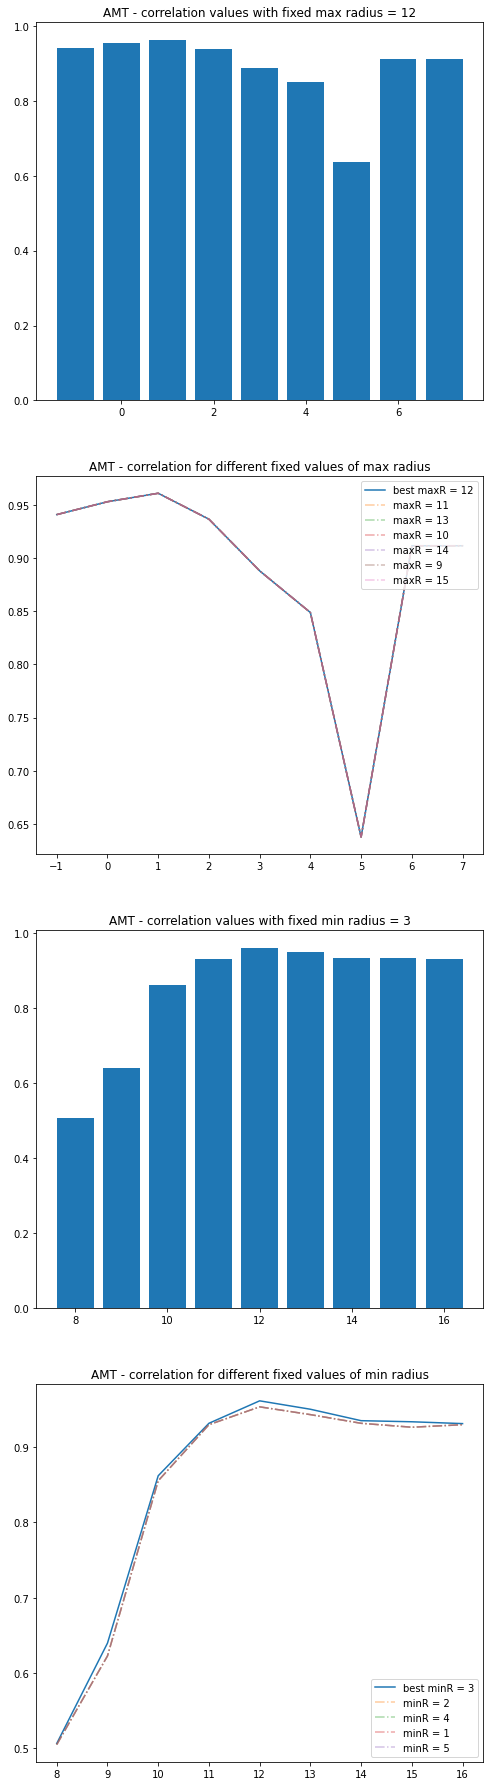

In [2136]:
fig, ax_bar = plt.subplots(4,1, figsize=(8,32))

ax_bar[0].bar(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, :, best_MaxR_idx])
ax_bar[0].set_title('AMT - correlation values with fixed max radius = '+str(best_maxR_adaptive))

ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, :, best_MaxR_idx], label='best maxR = ' + str(best_maxR_adaptive))
for j in np.arange(1,4,1):
    ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, :, best_MaxR_idx], '-.', alpha = 0.4,  label="maxR = " +str(best_maxR_adaptive-j))
    ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, :, best_MaxR_idx], '-.', alpha = 0.4, label="maxR = " +str(best_maxR_adaptive+j))
ax_bar[1].legend(loc = 'upper right')
ax_bar[1].set_title('AMT - correlation for different fixed values of max radius')


ax_bar[2].bar(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, best_MinR_idx, :])
ax_bar[2].set_title('AMT - correlation values with fixed min radius = '+str(best_minR_adaptive))

ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, best_MinR_idx, :], label='best minR = ' + str(best_minR_adaptive))
for j in np.arange(1,4,1):
    if (best_minR_adaptive-j >0):
        ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, best_MinR_idx-1, :], '-.', alpha = 0.4,  label="minR = " +str(best_minR_adaptive-j))
        ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_mean[best_B_idx,best_C_idx, best_MinR_idx-1, :], '-.', alpha = 0.4, label="minR = " +str(best_minR_adaptive+j))
ax_bar[3].legend(loc = 'lower right')
ax_bar[3].set_title('AMT - correlation for different fixed values of min radius')

plt.savefig(os.path.join(result_path, 'AMT_minMaxRadius_distribution.pdf'))


In [2137]:
######################## ADAPTIVE GAUSSIAN THREE PARAMS GRID SEARCH######################

In [2138]:
maxC = 60
minBsize = 3
maxBsize = 50

maxRadius = 50
minR =  best_minR_twoWay
struct_load = load_obj(dir_save = result_path_objs, file_name = 'adaptive_gauss_correl_dict')

if struct_load==None:

    adaptive_gauss_correl_dict = {}

    df_adaptive_gauss = np.zeros(shape=(len(range(0,maxC,4)),len(range(minBsize,maxBsize,2)), 1, maxRadius ))
    
    idx_C =-1   
    #for maxRadius in range(11,41,2):
    for C in range(0,maxC,4):
        idx_C = idx_C + 1  
        idx_b =-1
        for bsize in range(minBsize,maxBsize,4):
            idx_b = idx_b + 1
            #for minR in best_minR_twoWay:
            for maxR in range(15,45,1):            
                correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                adaptive_gauss_correl_dict[(bsize, C, minR, maxR)] = correl  
                df_adaptive_gauss[idx_C, idx_b, 0, maxR-1] = correl

    save_obj( obj = (adaptive_gauss_correl_dict, df_adaptive_gauss), dir_save = result_path_objs, file_name = 'adaptive_gauss_correl_dict')
else:
    adaptive_gauss_correl_dict = struct_load[0] 
    df_adaptive_gauss = struct_load[1]

    # get key with max value
(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive) = max(adaptive_gauss_correl_dict, key=adaptive_gauss_correl_dict.get)

print("best correlation on training set = "+str(adaptive_gauss_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE_GAUSSIAN ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


best correlation on training set = 0.969501551920812 at Radiuses = 4, 24 - C = 40 - blocksize = 3
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 4, maxR = 24
merging the dataframes
(50, 3)
correlation on test images [with best params: minR = 4 - maxR = 24 - C = 40 - blocksize3] = 0.3850963242399237


In [2139]:
######################### ADAPTIVE GAUSSIAN BEST C AND BSIZE RADIUSES SEARCH######################

In [2140]:
bsize = best_b_size_adaptive
C = best_C_adaptive    
maxRadius = 50

struct_load = load_obj(dir_save = result_path_objs, file_name = 'adaptive_gauss_correl_dict_radiuses')

if struct_load==None:
    print('create dict')
    adaptive_mean_correl_dict = {}
    df_adaptive_mean = np.zeros(shape=(maxRadius, maxRadius ))
    for minR in range(1,maxRadius,1):
        for maxR in range(minR+1,maxRadius,1):            
            correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
            adaptive_mean_correl_dict[(minR, maxR)] = correl  
            df_adaptive_mean[minR-1, maxR-1] = correl

    save_obj( obj = (adaptive_mean_correl_dict, df_adaptive_mean), dir_save = result_path_objs, file_name = 'adaptive_gauss_correl_dict_radiuses')
else:
    adaptive_mean_correl_dict = struct_load[0] 
    df_adaptive_mean = struct_load[1]

    # get key with max value
(best_minR_adaptive, best_maxR_adaptive) = max(adaptive_mean_correl_dict, key=adaptive_mean_correl_dict.get)

print("best correlation = "+str(adaptive_mean_correl_dict[(best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE GAUSSIAN CORRELATION ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


best correlation = 0.9984603532054124 at Radiuses = 27, 45 - C = 40 - blocksize = 3
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 3 - C = 40
 - Hough minR = 27, maxR = 45
merging the dataframes
(50, 3)
correlation on test images [with best params: minR = 27 - maxR = 45 - C = 40 - blocksize3] = 0.5146225321121173


In [2141]:
############ GLOBAL ADAPTIVE GAUSSIAN PARAM SEARCH ####################

In [2142]:
struct_load = load_obj(dir_save = result_path_objs, file_name = 'global_adaptive_gauss_correl_dict')

if struct_load==None:

    adaptive_gauss_correl_dict = {}

    df_adaptive_gauss = np.zeros(shape=(10, 5, 9, 9))

    idx_C =-1   
    for C in range(best_C_adaptive-9,best_C_adaptive+10,2):
        idx_C = idx_C + 1  
        idx_b =-1
        if best_b_size_adaptive == 3:
            for bsize in range(best_b_size_adaptive,best_b_size_adaptive+9,2):
                idx_b = idx_b + 1
                idx_minR =-1
                for minR in range(best_minR_adaptive-4,best_minR_adaptive+5,1):
                    idx_minR = idx_minR + 1
                    idx_maxR =-1
                    for maxR in range(best_maxR_adaptive-4,best_maxR_adaptive+5,1):
                        idx_maxR = idx_maxR + 1
                        correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                        adaptive_gauss_correl_dict[(bsize, C, minR, maxR)] = correl  
                        df_adaptive_gauss[idx_C, idx_b, idx_minR, idx_maxR] = correl
        else:
            for bsize in range(best_b_size_adaptive-4,best_b_size_adaptive+5,2):
                idx_b = idx_b + 1
                idx_minR =-1
                for minR in range(best_minR_adaptive-4,best_minR_adaptive+5,1):
                    idx_minR = idx_minR + 1
                    idx_maxR =-1
                    for maxR in range(best_maxR_adaptive-4,best_maxR_adaptive+5,1):
                        idx_maxR = idx_maxR + 1
                        correl = thresholding_Hough_correl(norm_dict_train, thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = minR , max_Radius = maxR, blocksize= bsize, constant=  C)
                        adaptive_gauss_correl_dict[(bsize, C, minR, maxR)] = correl  
                        df_adaptive_gauss[idx_C, idx_b, idx_minR, idx_maxR] = correl

    save_obj(obj = (adaptive_gauss_correl_dict, df_adaptive_gauss), dir_save = result_path_objs, file_name = 'global_adaptive_gauss_correl_dict')
else:
    adaptive_gauss_correl_dict = struct_load[0] 
    df_adaptive_gauss = struct_load[1]

    # get key with max value
(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive) = max(adaptive_gauss_correl_dict, key=adaptive_gauss_correl_dict.get)

print("best correlation on training set = "+str(adaptive_gauss_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])+" at Radiuses =" , str(best_minR_adaptive)+ ", "+str(best_maxR_adaptive)+ " - C = "+str(best_C_adaptive)+ " - blocksize = "+str(best_b_size_adaptive))



#################### ADAPTIVE GAUSSIAN ON TEST IMAGES WITH BEST PARAMS #########################################

correl = thresholding_Hough_correl(norm_dict_test,thresholding = 'ADAPTIVE_GAUSSIAN', min_Radius = best_minR_adaptive, max_Radius= best_maxR_adaptive, blocksize = best_b_size_adaptive, constant = best_C_adaptive)

print("correlation on test images [with best params: minR = "+str(best_minR_adaptive)+" - maxR = "+ str(best_maxR_adaptive) + " - C = "+ str(best_C_adaptive) + " - blocksize"+ str(best_b_size_adaptive) + "] = " + str(correl))


best correlation on training set = 0.9449111825230679 at Radiuses = 27, 45 - C = 49 - blocksize = 5
working on thresholding method = ADAPTIVE_GAUSSIAN, blocksize = 5 - C = 49
 - Hough minR = 27, maxR = 45
merging the dataframes
(50, 3)
correlation on test images [with best params: minR = 27 - maxR = 45 - C = 49 - blocksize5] = 0.5149672002623528


In [2143]:
best_params_index = np.where(df_adaptive_gauss == adaptive_gauss_correl_dict[(best_b_size_adaptive, best_C_adaptive, best_minR_adaptive, best_maxR_adaptive)])
best_B_idx = best_params_index[0][0]
best_C_idx = best_params_index[1][0]
best_MinR_idx = best_params_index[2][0]
best_MaxR_idx = best_params_index[3][0]
best_params_index

(array([9]), array([1]), array([4]), array([4]))

In [2144]:
df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx, best_MaxR_idx]

0.9449111825230679

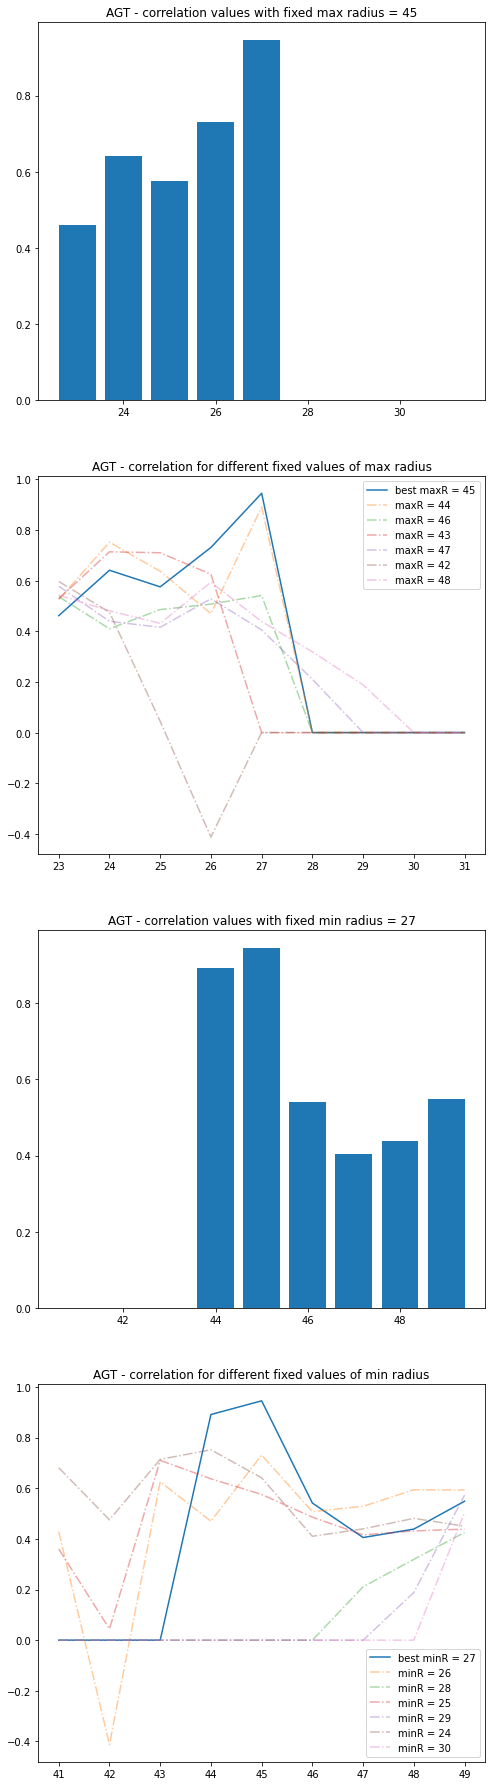

In [2145]:
fig, ax_bar = plt.subplots(4,1, figsize=(8,32))

ax_bar[0].bar(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, :, best_MaxR_idx])
ax_bar[0].set_title('AGT - correlation values with fixed max radius = '+str(best_maxR_adaptive))

ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, :, best_MaxR_idx], label='best maxR = ' + str(best_maxR_adaptive))
for j in np.arange(1,4,1):
    ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, :, best_MaxR_idx-j], '-.', alpha = 0.4,  label="maxR = " +str(best_maxR_adaptive-j))
    ax_bar[1].plot(np.arange(best_minR_adaptive-4,best_minR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, :, best_MaxR_idx+j], '-.', alpha = 0.4, label="maxR = " +str(best_maxR_adaptive+j))
ax_bar[1].legend(loc = 'upper right')
ax_bar[1].set_title('AGT - correlation for different fixed values of max radius')


ax_bar[2].bar(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx, :])
ax_bar[2].set_title('AGT - correlation values with fixed min radius = '+str(best_minR_adaptive))

ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx, :], label='best minR = ' + str(best_minR_adaptive))
for j in np.arange(1,4,1):
    if (best_minR_adaptive-j >0):
        ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx-j, :], '-.', alpha = 0.4,  label="minR = " +str(best_minR_adaptive-j))
        ax_bar[3].plot(np.arange(best_maxR_adaptive-4,best_maxR_adaptive+5,1),df_adaptive_gauss[best_B_idx, best_C_idx, best_MinR_idx+j, :], '-.', alpha = 0.4, label="minR = " +str(best_minR_adaptive+j))
ax_bar[3].legend(loc = 'lower right')
ax_bar[3].set_title('AGT - correlation for different fixed values of min radius')

plt.savefig(os.path.join(result_path, 'AGT_minMaxRadius_distribution.pdf'))
